# Table of Contents
* [Introduction and Class Instantiation](#intro)
* [Dataset Exploration and Preparation](#eda)

    * [Loading from Kaggle and Basic Info](#load)
    * [EDA Profile](#pandasprofile)
    * [Cleaning up and Preparing the Dataset](#cleanup)
        * [Duplicates](#duplicates)
        * [Irrelevant or columns or irrelevant observations](#irrelevant)
        * [Missing values](#missing)
        * [Essential Fields](#essential)
        * [Inferring Genres and Show Types](#classification)
        * [URLs](#urls)
* [Sending Data to Pinecone Index](#pinecone)
* [Candidates Retrieval and Generating Final Recommendations](#rag)
* [Testing out the RAG-based Recommender](#test)

## Introduction and Class Instantiation <a class="anchor" id="intro"></a>

The dataset used in this project is a [comprehensive movie database collected from TMBD API](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies) by Asaniczka, and themoviedb.org and available as Kaggle dataset.

     Asaniczka, and themoviedb.org. (2025). Full TMDB Movies Dataset 2024 (1M Movies) [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/10601279

In [1]:
#libraries
import numpy as np 
import pandas as pd
import pinecone
import os
import torch
from functools import reduce
import itertools
import pickle
import zipfile
from ydata_profiling import ProfileReport
from datetime import datetime
from tqdm import tqdm
import nltk
import time
import math
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import missingno as msno
import warnings
import logging

#modules
from zero_shot_llm_classification import ZeroShotOllamaClassifier
from pinecone_helpers import CustomDocumentLoader, CustomRetriever
from rag_helpers import RecRag
from settings import *

#config
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.simplefilter(action='ignore')
%matplotlib inline

In [2]:
#instantiate classes from modules
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#for zero-shot classification with LLM
classifier = ZeroShotOllamaClassifier()

#for processing and sending to Pinecone index
document_loader = CustomDocumentLoader(device=device)

#for candidate retrieval from Pinecone
retriever = CustomRetriever(dense_model_name=DENSE_VECTOR_MODEL, device=device)

#for generating final recommendations
rag_recommender = RecRag()

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: intfloat/e5-base-v2
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
INFO:sentence_transformers.SentenceTransformer:Load pretrain

## Dataset Exploration and Preparation <a class="anchor" id="eda"></a>

### Loading from Kaggle and Basic Info <a class="anchor" id="load"></a>

In [5]:
#load and unzip the dataset
! kaggle datasets download asaniczka/tmdb-movies-dataset-2023-930k-movies --force
with zipfile.ZipFile('tmdb-movies-dataset-2023-930k-movies.zip', 'r') as folder:
    with folder.open('TMDB_movie_dataset_v11.csv') as file:
        film_df = pd.read_csv(file, parse_dates=['release_date'])


  0%|          | 0.00/209M [00:00<?, ?B/s]
  0%|          | 1.00M/209M [00:00<01:57, 1.86MB/s]
  1%|▏         | 3.00M/209M [00:00<00:40, 5.37MB/s]
  3%|▎         | 7.00M/209M [00:00<00:17, 12.3MB/s]
  4%|▍         | 9.00M/209M [00:01<00:20, 10.1MB/s]
  6%|▌         | 12.0M/209M [00:01<00:15, 13.3MB/s]
  7%|▋         | 15.0M/209M [00:01<00:13, 15.0MB/s]
  9%|▊         | 18.0M/209M [00:01<00:14, 13.8MB/s]
 11%|█         | 23.0M/209M [00:01<00:09, 20.2MB/s]
 13%|█▎        | 28.0M/209M [00:01<00:07, 26.0MB/s]
 16%|█▌        | 33.0M/209M [00:02<00:05, 31.0MB/s]
 19%|█▊        | 39.0M/209M [00:02<00:04, 36.6MB/s]
 21%|██        | 44.0M/209M [00:02<00:04, 39.2MB/s]
 23%|██▎       | 49.0M/209M [00:02<00:04, 34.1MB/s]
 25%|██▌       | 53.0M/209M [00:02<00:04, 34.8MB/s]
 27%|██▋       | 57.0M/209M [00:02<00:04, 33.5MB/s]
 30%|██▉       | 62.0M/209M [00:02<00:04, 36.2MB/s]
 32%|███▏      | 67.0M/209M [00:02<00:03, 39.4MB/s]
 34%|███▍      | 72.0M/209M [00:03<00:03, 41.9MB/s]
 37%|███▋      | 77.

Dataset URL: https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies
License(s): ODC Attribution License (ODC-By)



In [6]:
logging.info(f"The loaded dataset contains {film_df.shape[0]} rows and {film_df.shape[1]} columns:\n- {film_df.select_dtypes('int64').shape[1]} of type integer\n- {film_df.select_dtypes('float64').shape[1]} of type float\n- {film_df.select_dtypes('object').shape[1]} of type object\n- {film_df.select_dtypes('bool').shape[1]} of type boolean\n- {film_df.select_dtypes('datetime').shape[1]} of type datetime")
film_df.dtypes

INFO:root:The loaded dataset contains 1177898 rows and 24 columns:
- 5 of type integer
- 2 of type float
- 15 of type object
- 1 of type boolean
- 1 of type datetime


id                               int64
title                           object
vote_average                   float64
vote_count                       int64
status                          object
release_date            datetime64[ns]
revenue                          int64
runtime                          int64
adult                             bool
backdrop_path                   object
budget                           int64
homepage                        object
imdb_id                         object
original_language               object
original_title                  object
overview                        object
popularity                     float64
poster_path                     object
tagline                         object
genres                          object
production_companies            object
production_countries            object
spoken_languages                object
keywords                        object
dtype: object

### EDA Profile <a class="anchor" id="pandasprofile"></a>

Let's start with a quick overview EDA using Pandas Profiling.

In [7]:
#get stopwords for all available languages to filter them out of wordclouds in EDA
nltk.download("stopwords")
all_stopwords = list(reduce(lambda a, b: a.union(b), [set(stopwords.words(language)) for language in stopwords.fileids()]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eremi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
eda_profile = ProfileReport(film_df,
                            progress_bar=True,
                            title='Movie Data from TMDB',
                            dataset={
                                    "description": "EDA of TMDB Movie Dataset. Dataset Source: Asaniczka, and themoviedb.org. (2025). Full TMDB Movies Dataset 2024 (1M Movies) [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/10601279",
                                    "copyright_holder": "ekaterinaleks",
                                    "copyright_year": 2025,
                                    "url": "https://github.com/ekaterinaleks/RAG",
                            },
                            variables={
                                "descriptions": {
                                    "id": "Unique identifier for each movie",
                                    "title": "Title of the movie",
                                    "vote_average": "Average vote or rating given by viewers",
                                    "vote_count": "Total count of votes received for the movie",
                                    "status": "The status of the movie (e.g., Released, Rumored, Post Production, etc.)",
                                    "release_date": "Date when the movie was released",
                                    "revenue": "Total revenue generated by the movie",
                                    "runtime": "Duration of the movie in minutes",
                                    "adult": "Indicates if the movie is suitable only for adult audiences",
                                    "backdrop_path": "URL of the backdrop image for the movie",
                                    "budget": "Budget allocated for the movie",
                                    "homepage": "Official homepage URL of the movie",
                                    "imdb_id": "IMDb ID of the movie",
                                    "original_language": "Original language in which the movie was produced",
                                    "original_title": "Original title of the movie",
                                    "overview": "Brief description or summary of the movie",
                                    "popularity": "Popularity score of the movie",
                                    "poster_path": "URL of the movie poster image",
                                    "tagline": "Catchphrase or memorable line associated with the movie",
                                    "genres": "List of genres the movie belongs to",
                                    "production_companies": "List of production companies involved in the movie",
                                    "production_countries": "List of countries involved in the movie production",
                                    "spoken_languages": "List of languages spoken in the movie",
                                    "keywords": "Keywords associated with the movie"
                                },
                            },
                            vars={"cat":{
                                "characters": False,
                                "stop_words": all_stopwords
                            },
                            "text":{
                                "characters": False,
                                "stop_words": all_stopwords
                            },
                            },
                            type_schema={"id": "Categorical",
                                        "status": "Categorical",
                                        "backdrop_path": "URL",
                                        "title": "Text",
                                        "vote_average": "Numeric",
                                        "vote_count": "Numeric",
                                        "release_date": "DateTime",
                                        "revenue": "Numeric",
                                        "runtime": "Numeric",
                                        "adult": "Boolean",
                                        "budget": "Numeric",
                                        "homepage": "URL",
                                        "imdb_id": "Categorical",
                                        "original_language": "Categorical",
                                        "original_title": "Text",
                                        "overview": "Text",
                                        "popularity": "Numeric",
                                        "poster_path": "URL",
                                        "tagline": "Text",
                                        "genres": "Categorical",
                                        "production_companies": "Categorical",
                                        "production_countries": "Categorical",
                                        "spoken_languages": "Categorical",
                                        "keywords": "Text"
                                         },
                            missing_diagrams={
                                    "bar": True,
                                    "matrix": False,
                                    "heatmap": False
                            },
                            correlations=None
)
eda_profile.config.vars.url.active = True

In [9]:
eda_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
eda_profile.to_file("tmdb_eda_profile.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Cleaning up and Preparing the Dataset <a class="anchor" id="cleanup"></a>

#### Duplicates <a class="anchor" id="duplicates"></a>
According to the profile, there are 348 duplicate rows that'll need to be deduplicated (up to 4 duplicates per unique row).

In [11]:
film_df.drop_duplicates(inplace=True)
print(f"Are there any complete duplicates left?\n- {film_df.duplicated().any()}")

Are there any complete duplicates left?
- False


Although we deleted all complete duplicates, there still might be several slightly different entries for the same title.

In [12]:
film_df[film_df.duplicated(['id', 'title'], keep=False)].sort_values('id', ascending=False).head(4)

id                                              title  \
595493  1433615  Zaho de Sagazan, le dernier des voyages au « L...   
594817  1433615  Zaho de Sagazan, le dernier des voyages au « L...   
594151  1433102                                              SIMON   
594150  1433102                                              SIMON   

        vote_average  vote_count    status release_date  revenue  runtime  \
595493           0.0           0  Released          NaT        0        0   
594817           0.0           0  Released   2025-02-13        0        0   
594151           0.0           0  Released          NaT        0       13   
594150           0.0           0  Released          NaT        0        0   

        adult                     backdrop_path  ...  \
595493  False                               NaN  ...   
594817  False  /8UQ3SAFlLGHjMzapt8x1S3gnxbh.jpg  ...   
594151  False                               NaN  ...   
594150  False                               NaN  ...   

                                           original_title  \
595493  Zaho de Sagazan, le dernier des voyages au « L...   
594817  Zaho de Sagazan, le dernier des voyages au « L...   
594151                                              SIMON   
594150                                              SIMON   

                                                 overview popularity  \
595493                                                NaN        0.0   
594817                                                NaN        1.4   
594151  A complete loser is hit with the sudden realit...        0.6   
594150                                                NaN        0.0   

                             poster_path  \
595493                               NaN   
594817  /fmwR04djByTK6jkWZgs4mRihvLZ.jpg   
594151                               NaN   
594150                               NaN   

                                                  tagline  genres  \
595493                                                NaN     NaN   
594817                                                NaN   Music   
594151  FROM THE DIRECTOR OF ‘THANATOPHOBIA’ AND ‘SPEA...  Comedy   
594150                                                NaN     NaN   

             production_companies production_countries spoken_languages  \
595493                        NaN                  NaN              NaN   
594817  CultureBox, Sombrero & Co               France           French   
594151                        NaN                  NaN              NaN   
594150                        NaN                  NaN              NaN   

            keywords  
595493           NaN  
594817  concert film  
594151           NaN  
594150           NaN  

[4 rows x 24 columns]

Apparently, some of the duplicates are due to mismatched metadata that probably was added or removed later, in some cases due to status change, e.g. from "In production" to "Released".

Let's combine these duplicated observations to get only one unique row, maintaning all available metadata from all versions:
- first back fill and forward fill on null values
- then take the maximum observation for numeric values like vote, popularity, etc.

In [13]:
duplicated_index = film_df[film_df.duplicated(['id', 'title'], keep=False)].index.tolist()

In [15]:
#forward and back fill of null values in the duplicated groups
for column in film_df.columns.drop(['id', 'title']):
    film_df.loc[duplicated_index, column] = film_df.loc[duplicated_index].groupby(['id', 'title'])[column].transform(lambda x: x.bfill())
    film_df.loc[duplicated_index, column] = film_df.loc[duplicated_index].groupby(['id', 'title'])[column].transform(lambda x: x.ffill())

In [16]:
#take the maximum value for numeric and boolean fields in the duplicated groups
for num_column in film_df.select_dtypes(['int', 'bool', 'float']).columns.drop('id'):
    film_df.loc[duplicated_index, num_column] = film_df.loc[duplicated_index].groupby(['id', 'title'])[num_column].transform(lambda x: np.max(x))

In [17]:
#leave only the row with latest (logically) status
status_time_ordering = {'Canceled': 4,
                        'In Production': 2,
                        'Planned': 1,
                        'Post Production': 3,
                        'Released': 5,
                        'Rumored': 0
                        }
film_df = film_df.sort_values('status', key=lambda col: col.apply(lambda x: status_time_ordering[x]), ascending=False).drop_duplicates(['id','title'], keep='first')
film_df.reset_index(drop=True, inplace=True)
print(f"Are there any dupicated titles left?\n- {film_df.duplicated(['id', 'title']).any()}")

Are there any dupicated titles left?
- False


#### Irrelevant or columns or irrelevant observations <a class="anchor" id="irrelevant"></a>

##### Status
Most films have "Released" status, but there are some "Rumored" or "Cancelled" ones that we definetely wouldn't want to recommend.

For this case, let's leave only those released or in post production.

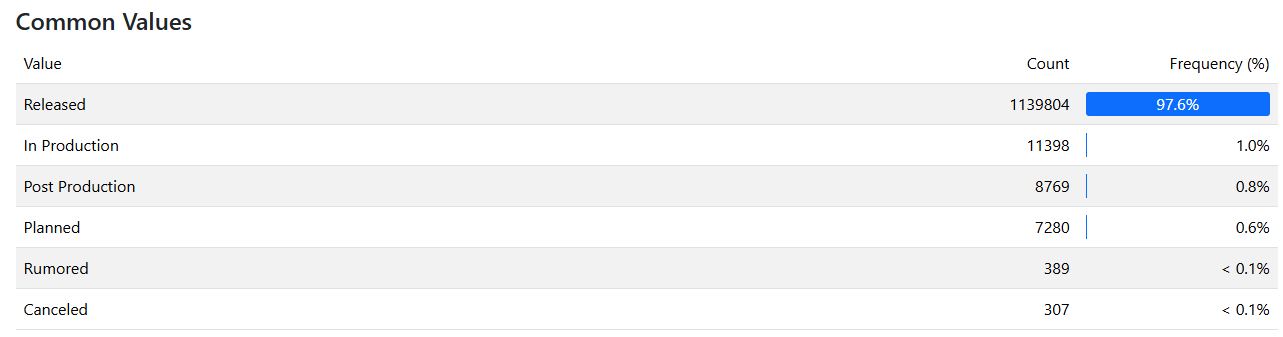

In [18]:
#leave only videos that were already released or are in post production
film_df = film_df.query('status.isin(["Released", "Post Production"])')

##### Popularity, vote average and vote count
This kind of fields could be interesting to use to probably order or prioritize retrieved results, but we don't need all three.
Also, let's minimize the proportion of obscure films by filtering out those with very low ratings.

In [19]:
film_df[['popularity', 'vote_average', 'vote_count']].describe()

popularity  vote_average    vote_count
count  1.157273e+06  1.157273e+06  1.157273e+06
mean   1.213260e+00  1.854818e+00  1.853509e+01
std    7.519218e+00  3.011791e+00  3.156680e+02
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    6.000000e-01  0.000000e+00  0.000000e+00
50%    6.000000e-01  0.000000e+00  0.000000e+00
75%    8.660000e-01  4.600000e+00  1.000000e+00
max    2.994357e+03  1.000000e+01  3.449500e+04

In [20]:
#let's leave only vote_average field and only observations with rating above 3 (out of 10)
film_df = film_df.drop(['popularity', 'vote_count'], axis=1)
film_df = film_df.query('vote_average > 3')

##### Adult

The proportion of films suitable only for adult audiences is 9.5%. For this particular recommender, let's drop this category.

In [21]:
#drop adult audience only films
film_df = film_df.query('adult == False')

In this task we won't be using a *budget*, *revenue* and a number of other metadata fields.

In [22]:
#drop fields that won't be used in the task because they either have only one category left, or aren't relevant for the task
film_df.drop(['budget', 'revenue', 'adult', 'status', 'poster_path', 'backdrop_path'], axis=1, inplace=True)

#### Missing values <a class="anchor" id="missing"></a>

The percetage of missing cells in the original dataset was rather high (26%) and needs to be explored further.

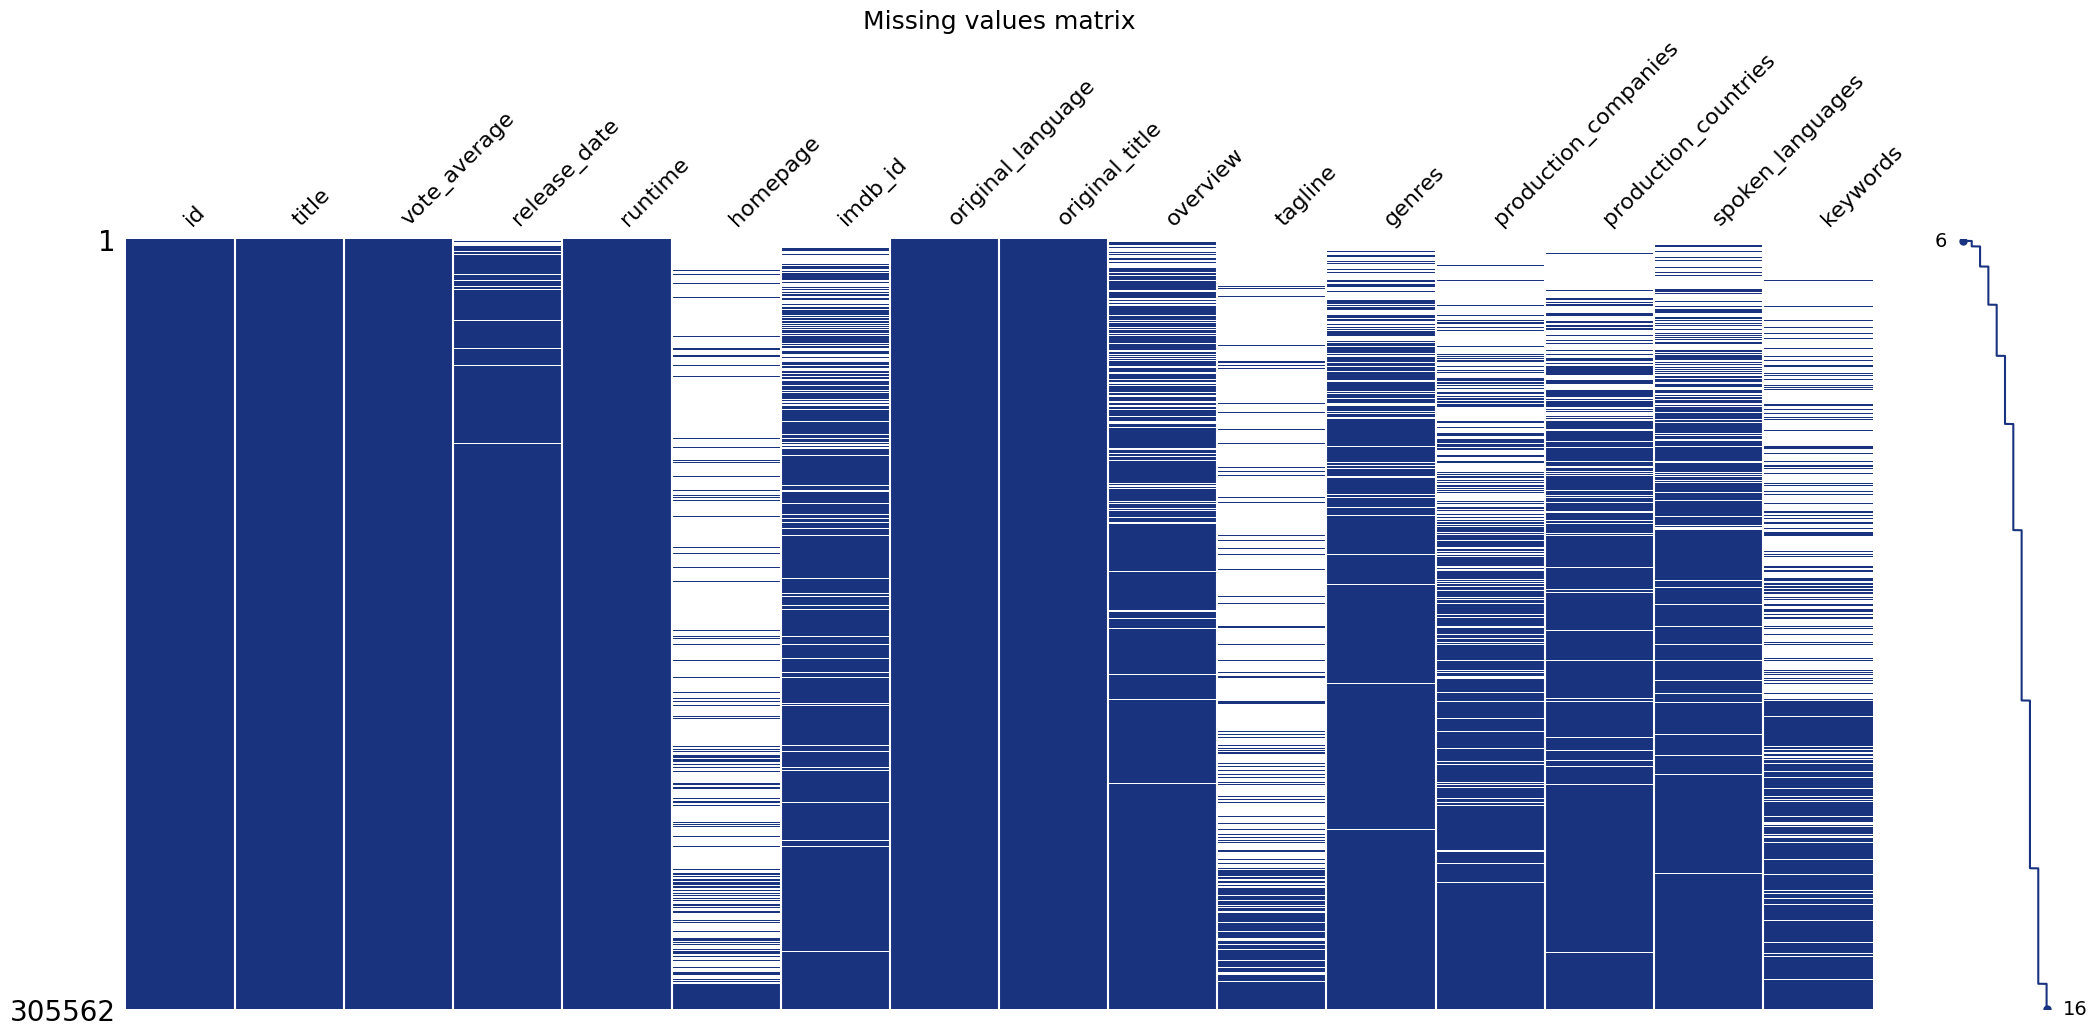

In [23]:
msno.matrix(film_df, sort='ascending', color=(0.1, 0.2, 0.5))
plt.title('Missing values matrix', fontsize=18)
plt.show()

#### Essential Fields <a class="anchor" id="essential"></a>


The essential fields for recommending films with RAG are movie title and some kind of description. We won't be able to use observations without this information.

##### Description

For description we have *overview* field that could be combined with *tagline* and *keywords* fields, both with quite a lot of null values.

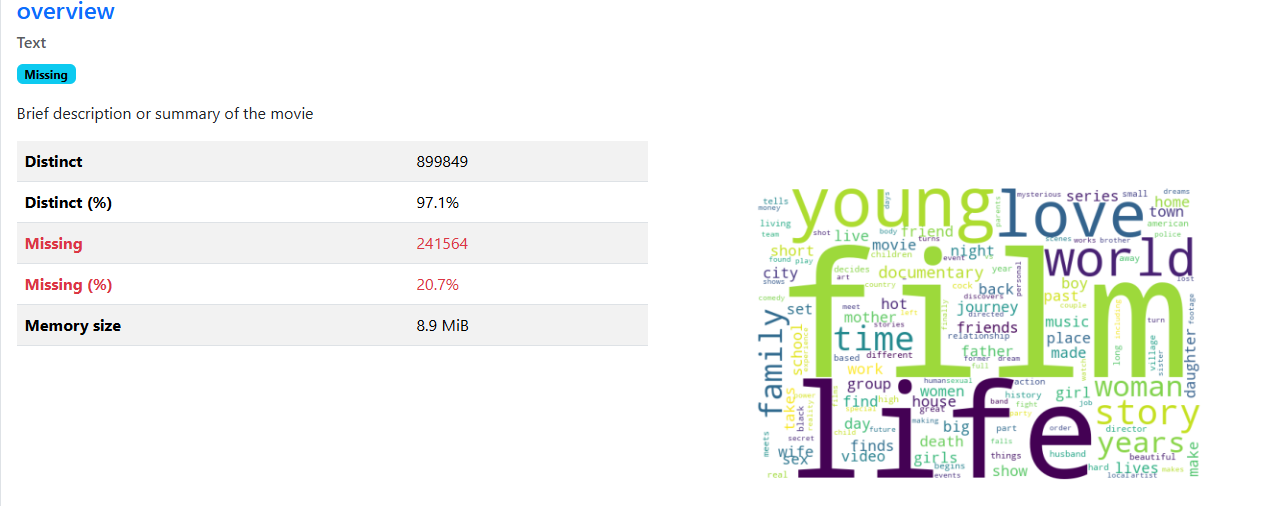

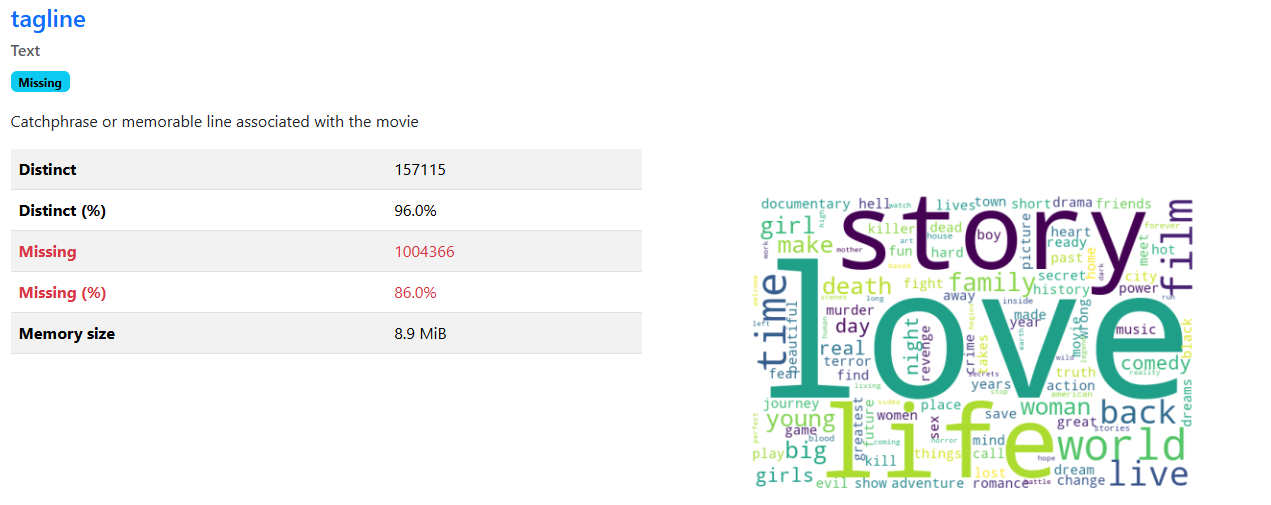

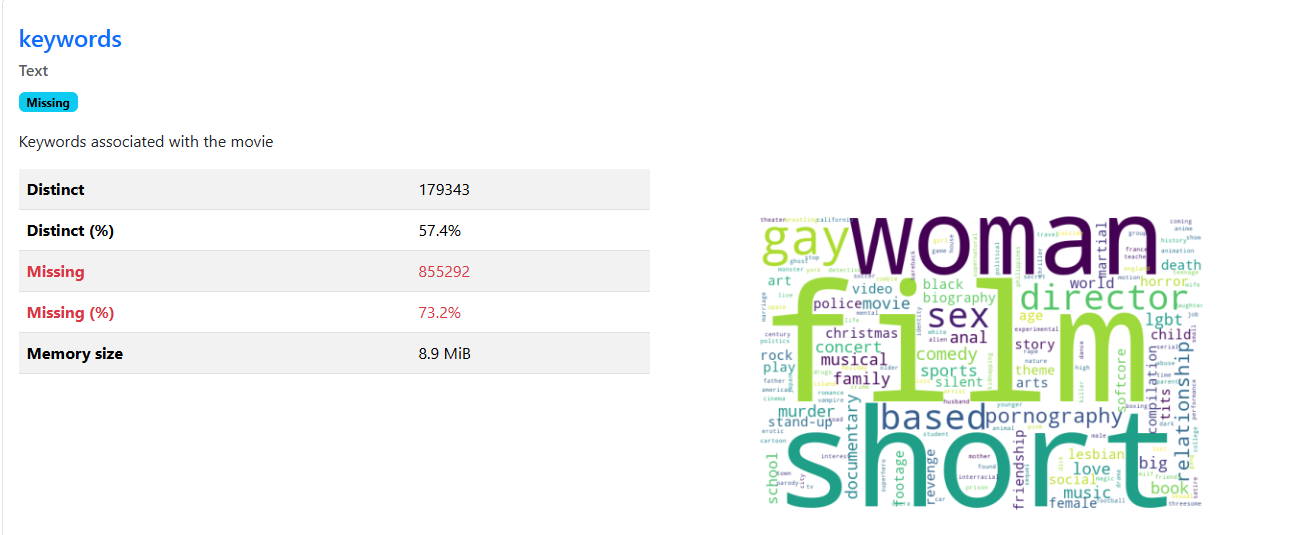


In [24]:
film_df = film_df.query('overview.notna()')
film_df = film_df[film_df['overview'].apply(len) > 2]

##### Title

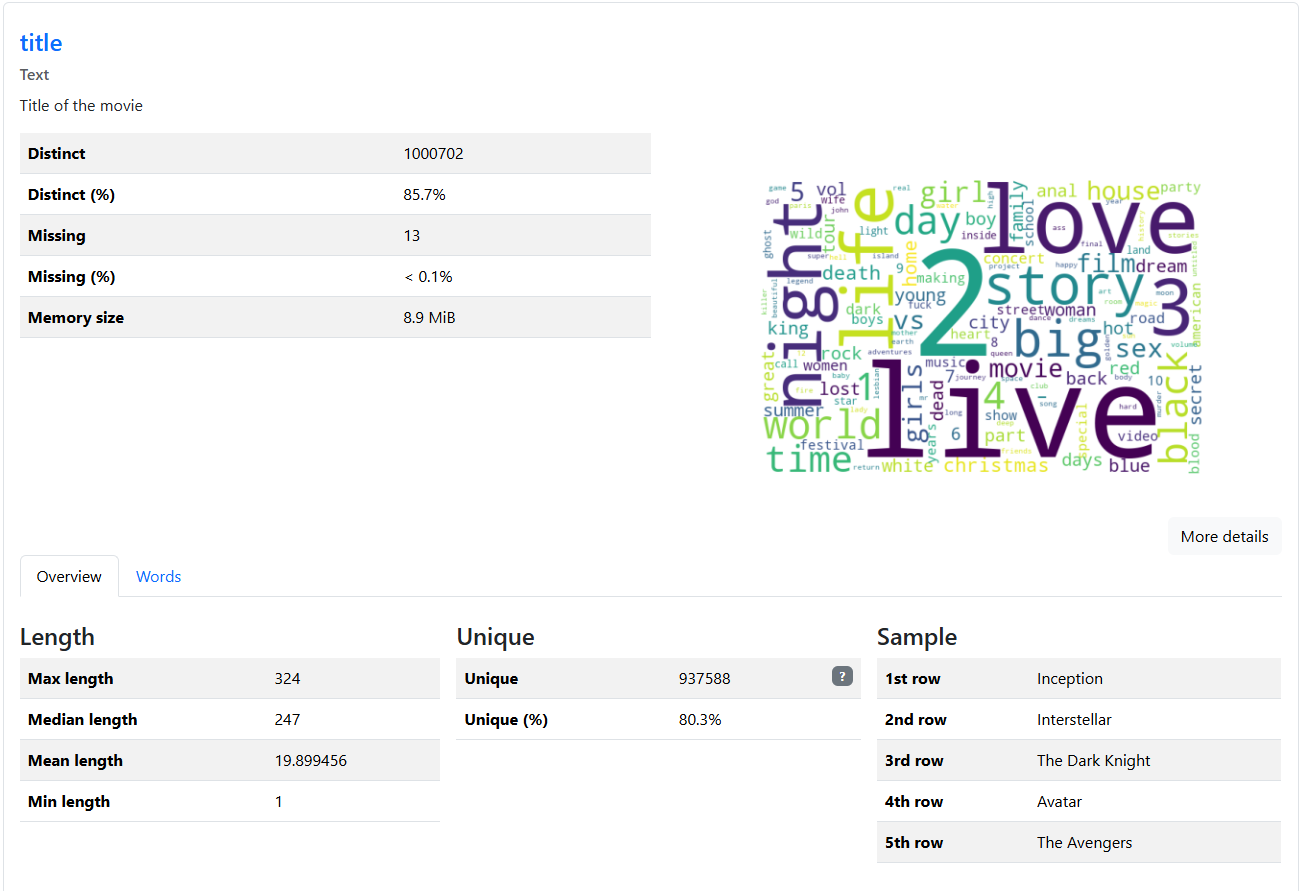

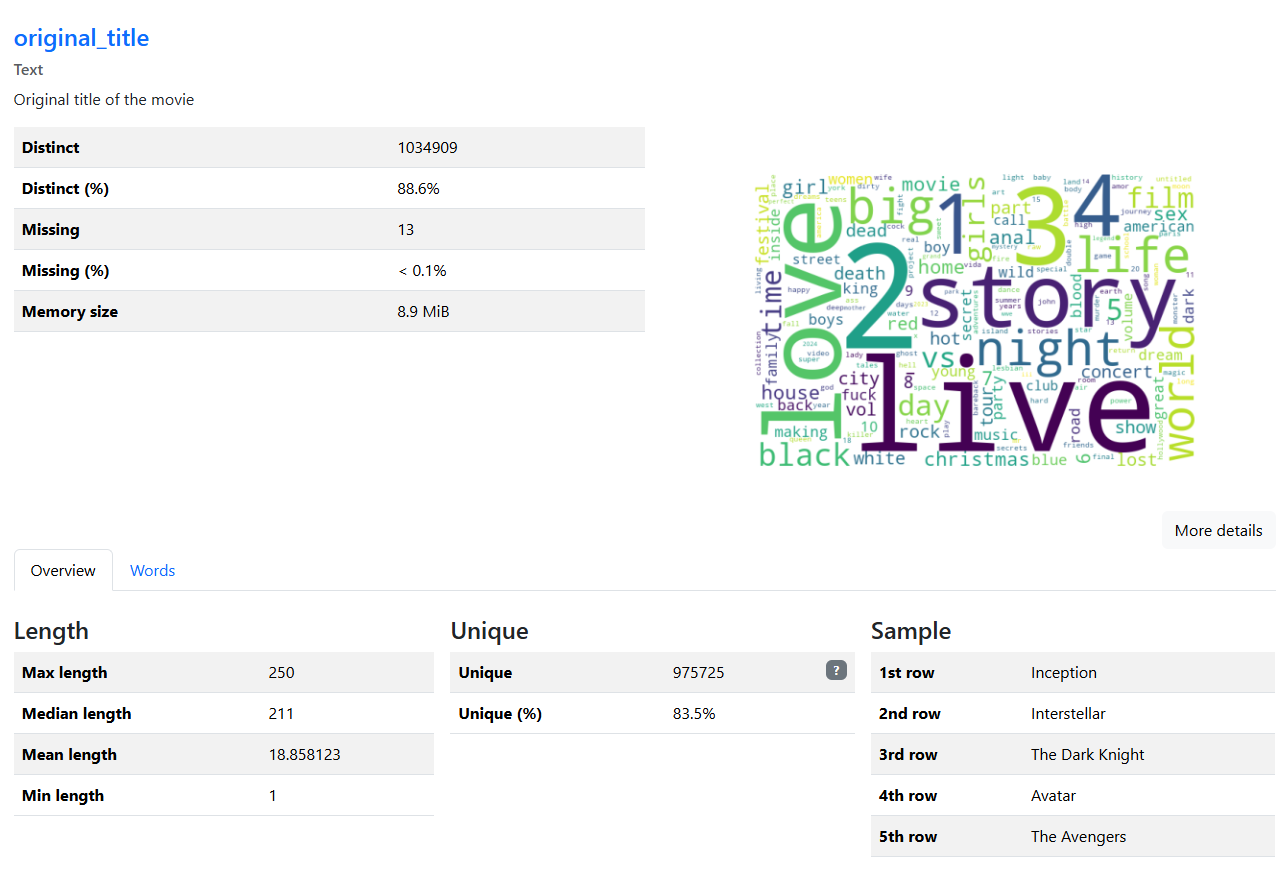

Both *title* and *original title* have some null values.

In [25]:
#drop rows with null title or original title
film_df.dropna(subset=['title', 'original_title'], axis=0, how='all', inplace=True)
film_df[['title', 'original_title']].isna().sum()

title             0
original_title    0
dtype: int64

Interestingly, the minumum length is 1 character but after a manual check it turns out that in most cases these are valid titles.

In [26]:
film_df.loc[film_df['title'].apply(len) < 2, ['id', 'title', 'original_title', 'overview']].head()

id title original_title  \
114194   615830     N              N   
581633  1003810     N              N   
582254   594641     W              W   
582303   594443     W              W   
583297   940267     X              X   

                                                 overview  
114194  Recorded during a presentation of the "Perform...  
581633  “N” as in Nurse.  A man wandering in an abando...  
582254  When we try to change the miscellaneous world ...  
582303  A freshman in university, Neung, finds the ent...  
583297  Eliza (Breanne Zill) is a head-in-clouds paint...

#### Inferring Genres and Show Types  <a class="anchor" id="classification"></a>

*Genres* field also can be considered as an essential one.

In [27]:
print(f"The problem with this field is that it has {round(film_df.genres.isna().sum()/len(film_df)*100)}% of missing values, but we could infer missing genres from overview and/or keywords.")

The problem with this field is that it has 11% of missing values, but we could infer missing genres from overview and/or keywords.


Apart from genres we are also missing another essential category: Show Type (e.g. Long-form movie, short-form movie, series, etc.)

We will be using an LLM as zero-shot classifier for inferring these two features from *overview*, *keywords* and *runtime* (for show type).

In [28]:
#get all unique genres from comma-separated lists of genres in genre field
genres_ref = reduce(lambda a, b: a.union(b),\
            filter(lambda x: x!= None,\
            [set(item.split(', ')) if type(item) != float else None for item in film_df.genres.unique().tolist()]))

In [29]:
try:
    with open('aux_classification.pkl', 'rb') as fhandle:
        records = pickle.load(fhandle)
        print('Loaded previous pickle')
except:
    records = film_df[['id', 'title', 'overview', 'runtime']].to_dict('records')
    print('Starting from scratch')

Loaded previous pickle


In [ ]:
if {len(item) if len(item) < 6 else None for item in records} != {None}:
    it = iter(records)
    chunk = tuple(itertools.islice(it, BATCH_SIZE))
    count=1
    total_chunks = math.ceil(len(records)/BATCH_SIZE)
    while chunk:
        if sum([True if len(item) < 6 else False for item in chunk]) > 0:
            for record in tqdm(chunk, desc=f"chunk {count} out of {total_chunks}"):
                if len(record) < 6:
                    try:
                        full_text = f"""Title: {record['title']}\nSummary: {record['overview']}\nRuntime: {record['runtime'] if type(record['runtime']) != float else "Unknown number of"} minutes"""
                        record['llm_genres'], record['llm_show_types'] = classifier.infer_genres_and_types(text=full_text, genres_ref=genres_ref)
                    except Exception as e:
                        print(f"Error: {e}")
            with open('aux_classification.pkl', 'wb') as fhandle:
                pickle.dump(records, fhandle)
            time.sleep(10)
        chunk = tuple(itertools.islice(it, BATCH_SIZE))
        count+=1
else:
    print('Nothing left to process')


Nothing left to process


In [31]:
inferred_df = pd.DataFrame(records)
inferred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271472 entries, 0 to 271471
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              271472 non-null  int64 
 1   title           271472 non-null  object
 2   overview        271472 non-null  object
 3   runtime         271472 non-null  int64 
 4   llm_genres      269867 non-null  object
 5   llm_show_types  269867 non-null  object
dtypes: int64(2), object(4)
memory usage: 12.4+ MB


In [32]:
film_df = film_df.merge(inferred_df[['id', 'llm_genres', 'llm_show_types']])

In [33]:
#convert comma-separated lists of genres into arrays and impute missing with llm-inferred genres
film_df['genres'] = film_df.genres.apply(lambda x: x.split(', ') if type(x) != float else None)
film_df.fillna({"genres": "llm_genres"}, inplace=True)
film_df.drop("llm_genres", axis=1, inplace=True)
film_df.genres.isna().sum()

0

#### URLs <a class="anchor" id="urls"></a>

It would be nice to include links to recommended films directly in RAG output, so that user can have a closer look on e.g. IMDB site and decide which recommendation to pick.

However, in the dataset we have homepage only for a small fraction of observations.

Luckily, both tmdb id and imdb id allow to form a link to movies' profiles. The thing to keep in mind though, is that TMDB changes the link prefix depending on show type: movie or series.

In [34]:
#compose links to movie databases
#the same pattern for all observations in IMBD
film_df.loc[film_df['imdb_id'].notna(), 'imbd_url'] = "https://www.imdb.com/title/" + film_df['imdb_id'].astype('string')

#different links for Movies and TV series in TMBD
film_df[film_df['runtime'] > 240].fillna({"llm_show_types": "TV Series"}, inplace=True)
film_df.fillna({"llm_show_types": "Movie"}, inplace=True)
film_df.loc[(film_df['llm_show_types'].apply(lambda x: ', '.join(x)).str.contains('TV Series')) & (film_df['runtime'] > 300), 'tmdb_url'] = "https://www.themoviedb.org/tv/" + film_df['id'].astype('string')
film_df.loc[(film_df['llm_show_types'].apply(lambda x: ', '.join(x)).str.contains('Movie')), 'tmdb_url'] = "https://www.themoviedb.org/movie/" + film_df['id'].astype('string')

In [35]:
#combine all available urls in one field
url_cols = ['homepage', 'tmdb_url', 'imbd_url']
film_df['sources'] = film_df[url_cols].apply(lambda x: {item : x[item] for item in list(filter(lambda a: type(x[a]) != float and x[a] != None, url_cols))}, axis=1)

In [36]:
#combine all available info in a page_content field
film_df['page_content'] = film_df[['tagline', 'overview', 'keywords', 'genres']]\
            .apply(lambda x: list(filter(lambda a: type(a[1]) != float, [items for items in x.to_dict().items()])), axis=1)\
            .apply(lambda x: [f"{item[0].upper()}: {item[1]}" for item in x])\
            .apply(lambda x: '\n'.join(x))

In [37]:
#preprocess page content
film_df['page_content'] = film_df['page_content'].apply(document_loader.normalize_overview)

In [38]:
#leave only rows with nonull preprocessed overview
film_df = film_df.query('page_content.notna()')

In [39]:
#impute missing object values with N/A
film_df.fillna(dict.fromkeys(film_df.select_dtypes('object').columns, "N/A"), inplace=True)

## Sending Data to Pinecone Index <a class="anchor" id="pinecone"></a>

In [40]:
#Pinecone client
pc = pinecone.Pinecone(api_key=os.getenv('PINECONE_API'), pool_threads=INDEX_POOL_THREADS)
index_name = INDEX_NAME

INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['c:\\Users\\eremi\\miniconda3\\envs\\rag_langchain_ollama\\Lib\\site-packages\\pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone


In [41]:
if index_name not in pc.list_indexes().names():
        print(f"Creating {index_name} index.")
        pc.create_index(
          name=index_name,
          metric="dotproduct",
          dimension=DENSE_DIM_NUMBER,
          spec=pinecone.ServerlessSpec(
                                    cloud="aws",
                                    region=INDEX_REGION
                                  )
        )
        while not pc.describe_index(index_name).status['ready']:
            time.sleep(1)

In [42]:
#connect to index
index = pc.Index(index_name)
print(f"Connected to {index_name}.")

INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['c:\\Users\\eremi\\miniconda3\\envs\\rag_langchain_ollama\\Lib\\site-packages\\pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference


Connected to tmdb-films.


In [43]:
#preprocess and turn to records
records = document_loader.turn_to_records(df=film_df[['id', 'page_content', 'sources', 'title', 'original_title', 'genres', 'llm_show_types', 'overview', 'production_countries', 'production_companies', 'vote_average', 'release_date']])

In [ ]:
#calculate dense and sparse vectors, send to Pinecone asynchronously in batches
results = document_loader.async_document_loader(records=records, index=index, batch_size=BATCH_SIZE)

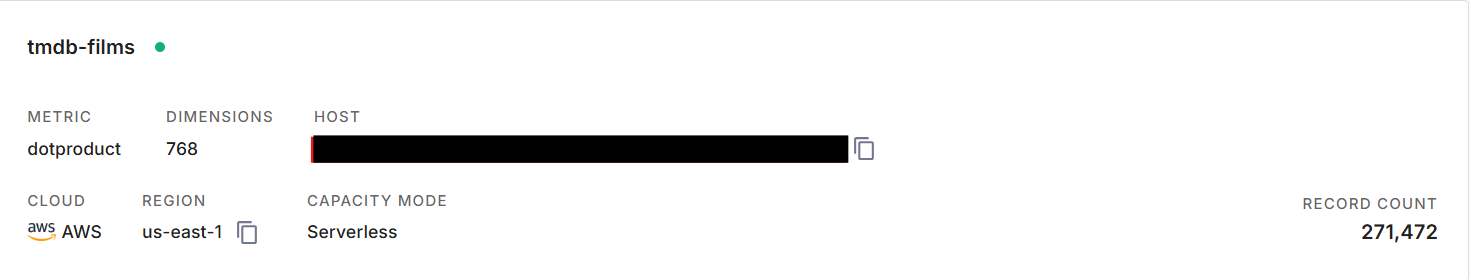

## Candidates Retrieval and Generating Final Recommendations <a class="anchor" id="rag"></a>

In [ ]:
def get_recommendations(query):

    #analyse user query and generate retriever filter based on it
    query_metadata = classifier.infer_query_metadata(query=query, genres_ref=genres_ref)
    metadata_filter = {}
    minimal_metadata_filter = {}
    minimal_metadata_filter["$or"] = []
    rating_filter = {"rating": {"$gte": 6.0}}
    for key in sorted(query_metadata.keys(), reverse=True):
        if query_metadata[key] and len(query_metadata[key]) > 0:
            if key == "years" and type(query_metadata['years'][0]) == int:
                metadata_filter["$and"] = []
                metadata_filter["$and"].append({"release_date_filter": {"$gte": datetime(min(query_metadata['years']),1, 1).timestamp()}})
                metadata_filter["$and"].append({"release_date_filter": {"$lte": datetime(max(query_metadata['years']), 12, 31).timestamp()}})
                logging.info(f"Looking for {key}(s): {(query_metadata[key])}")
            if key != "years":
                metadata_filter[key] = {"$in": query_metadata[key]}
                minimal_metadata_filter["$or"].append({key: {"$in": query_metadata[key]}})
                logging.info(f"Looking for {key}(s): {(query_metadata[key])}")
    

    #retrieve 3 batches of candidates with different filters
    retrieved_documents = []

    #with full filters applied
    retrieved_filtered_documents = retriever.retrieve_from_pinecone(index=index, query=query, metadata_filter = metadata_filter, top_k=20, alpha=0.5)
    titles = [item.metadata['title'] for item in retrieved_filtered_documents]
    retrieved_documents.extend(retrieved_filtered_documents)

    #with or-filters applied, and don't repeat already retrieved matches
    minimal_metadata_filter["title"] = {"$nin": titles}
    retrieved_or_filter_documents = retriever.retrieve_from_pinecone(index=index, query=query, metadata_filter = minimal_metadata_filter, top_k=10, alpha=0.5)
    add_titles = [item.metadata['title'] for item in retrieved_or_filter_documents]
    titles.extend(add_titles)
    retrieved_documents.extend(retrieved_or_filter_documents)

    #with rating-only filter, and don't repeat already retrieved matches
    rating_filter["title"] = {"$nin": titles}
    retrieved_rating_filter_documents = retriever.retrieve_from_pinecone(index=index, query=query, metadata_filter = rating_filter, top_k=10, alpha=0.5)
    retrieved_documents.extend(retrieved_rating_filter_documents)

    #pass the context and query to LLM to get recommendations
    answer = rag_recommender.get_final_recommendations(query=query, retrieved_context=retrieved_documents)
    return answer.reply, answer.recommendations

In [ ]:
def display_result(reply, recommendations):
    print(f"\n\n\nReply:\n{reply}")
    for num, item in enumerate(recommendations):
        print(f"Recommendation {num+1}:")
        print(f"\tTitle: {item.title}")
        print(f"\tGenres: {', '.join(item.genres)}")
        print(f"\tLinks: {item.sources}")
        print(f"\tRating: {item.rating}")
        print(f"\tReasoning: {item.reasoning}")

## Testing out the RAG-based Recommender <a class="anchor" id="test"></a>

#### Sci-fi thrillers with mind-bending plots

In [48]:
query="I love futuristic sci-fi thrillers with mind-bending plots. Any suggestions?"
reply, recommendations = get_recommendations(query)
display_result(reply, recommendations)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:root:Looking for show_types(s): ['Movie']
INFO:root:Looking for genres(s): ['Science Fiction', 'Thriller']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Reply:
Based on your love for futuristic sci-fi thrillers with mind-bending plots, here are five recommendations that perfectly match your preferences. 'The Name of the Prime Minister' delves into mystery and psychological twists, 'Go Don't Go' blends lost-love story and paranoia in a mind-bending narrative, 'The Clinic' offers thrilling mix of science fiction and horror with mind-bending elements, 'Hello Friend: The Incident' combines thriller, science fiction, and horror in a mysterious narrative, and 'Diegesis' provides an adventurous blend of action, mystery, horror, comedy, and adventure in a unique storyline.
Recommendation 1:
	Title: The Name of the Prime Minister
	Genres: Science Fiction, Drama, Thriller, Mystery
	Links: ['https://bizzythompson.com/the-name-of-the-prime-minister', 'https://www.themoviedb.org/movie/1060740', 'https://www.imdb.com/title/tt7784898']
	Rating: 10.0
	Reasoning: This recommendation is a perfect fit for your love of futuristic sci-fi thrillers with 

#### Documentaries about science

In [49]:
query="Recommend me a documentary about science."
reply, recommendations = get_recommendations(query)
display_result(reply, recommendations)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:root:Looking for genres(s): ['Documentary']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Reply:
I recommend "The Inexplicable Universe: Unsolved Mysteries" for its exploration of mysteries in the universe, "The Immortalists" for its focus on longevity research, "The Quantum Activist" for its paradigm shift in science, "Upper Story: On the Road to Well-Being" for its collaboration between scientists and scholars, and "Britain Can Make It, No. 1" for showcasing innovation in British industry.
Recommendation 1:
	Title: The Inexplicable Universe: Unsolved Mysteries
	Genres: Documentary
	Links: ['https://www.themoviedb.org/movie/1122436', 'https://www.imdb.com/title/tt4642162']
	Rating: 10.0
	Reasoning: This documentary explores unsolved mysteries of the universe, appealing to your interest in science and curiosity about the unknown.
Recommendation 2:
	Title: The Immortalists
	Genres: Documentary
	Links: ['https://www.themoviedb.org/movie/253263', 'https://www.imdb.com/title/tt3267194']
	Rating: 6.4
	Reasoning: The Immortalists follows two scientists on a quest for eternal y

#### Sci-fi or fantasy about humanoid cats

In [51]:
query="Recommend me a sci-fi movie or fantasy film about humanoid cats."
reply, recommendations = get_recommendations(query)
display_result(reply, recommendations)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:root:Looking for show_types(s): ['Movie']
INFO:root:Looking for genres(s): ['Science Fiction', 'Fantasy']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Reply:
Here are five recommendations for you:
1. Fantadrome: A colorful children's sci-fi cartoon featuring a shape-shifting robot in the form of a cat.
2. The Cat Who Walked by Himself: An enchanting animated short about a cat who walks alone in the wild.
3. The Cat's Out: An intriguing story about a cat causing trouble for birds and experiencing a nightmare.
4. The Hep Cat: A light-hearted animated film about a charming cat-about-town getting into funny situations.
5. O Lasanha: A short film about a cat named Lasagna with quirky behaviors that add humor and suspense to the story.
Recommendation 1:
	Title: Fantadrome
	Genres: Animation, Family, Science Fiction, Adventure
	Links: ['https://www.imdb.com/title/tt1882434']
	Rating: 5.0
	Reasoning: Fantadroms is a Latvian children's sci-fi cartoon featuring a yellow shape-shifting robot called Indrikis XIII, who usually takes the form of a cat. The show explores various disputes between characters in a colorful and humorous way.
Recomme

#### Book-based British detective series

In [ ]:
query="Recommend me some crime, detective or thriller tv-series based on a book and filmed in UK."
reply, recommendations = get_recommendations(query)
display_result(reply, recommendations)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:root:Looking for show_types(s): ['TV Series']
INFO:root:Looking for production_countries(s): ['United Kingdom']
INFO:root:Looking for genres(s): ['Crime', 'Detective', 'Thriller']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Reply:
I recommend 'The Woman in White' and 'The Hound of the Baskervilles: Sherlock the Movie' for their adaptation from books and UK filming locations. Additionally, 'Reichenbach Falls' offers a psychological thriller set in Edinburgh, while 'A Very English Murder' presents a classic detective story during Christmas. Lastly, 'Jigsaw' follows local detectives along the coast from Brighton in solving a murder case.
Recommendation 1:
	Title: The Woman in White
	Genres: Crime, Mystery
	Links: ['https://www.themoviedb.org/movie/629696', 'https://www.imdb.com/title/tt0161117']
	Rating: 8.0
	Reasoning: Based on the novel by Wilkie Collins, this detective-mystery film is set in Victorian England, meeting your criteria for a TV series based on a book and filmed in the UK.
Recommendation 2:
	Title: The Hound of the Baskervilles: Sherlock the Movie
	Genres: Mystery, Crime
	Links: ['https://baskervilles-movie.jp/', 'https://www.themoviedb.org/movie/886024', 'https://www.imdb.com/title/tt22814

## Conclusion

To conclude, let's have a closer look at the last, and the most detailed example query, ```"Recommend me some crime, detective or thriller TV-series based on a book and filmed in the UK."```

The system began by processing the user query, extracting key metadata. The logs reveal that the system identified the following filters for retrieval:

- Show Types: TV Series
- Production Countries: United Kingdom
- Genres: Crime, Detective, Thriller

Using this metadata, the retriever applied filters to prioritize observations with matching metadata and performed hybrid search combining dense and sparse vectors to retrieve the most relevant TV series. The relevant documents (top 40) were then evaluated to choose the best five recommendations.

The recommended videos are limited to the ones from the TMDB dataset, ensuring metadata info and less obvious and more novel recommendations.

The final output provided a conversational response along with detailed information, including links, ratings, and the reasoning behind each recommendation.